In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/{covid_utils, cfr}.py
import covid_utils as cv
import cfr

df = cfr.fetch_data()

In [132]:
smooth = cfr.smooth_active(df, level=3)  # wavelet reconstruction, per state
smooth.Reff = smooth.Reff.replace(np.inf, np.nan)
smooth.Reff[smooth.Reff > 10] = 10
smooth.Reff[smooth.Reff < 0.4] = 0.4
smooth = smooth.join(groups.rename('group'), on='state')


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

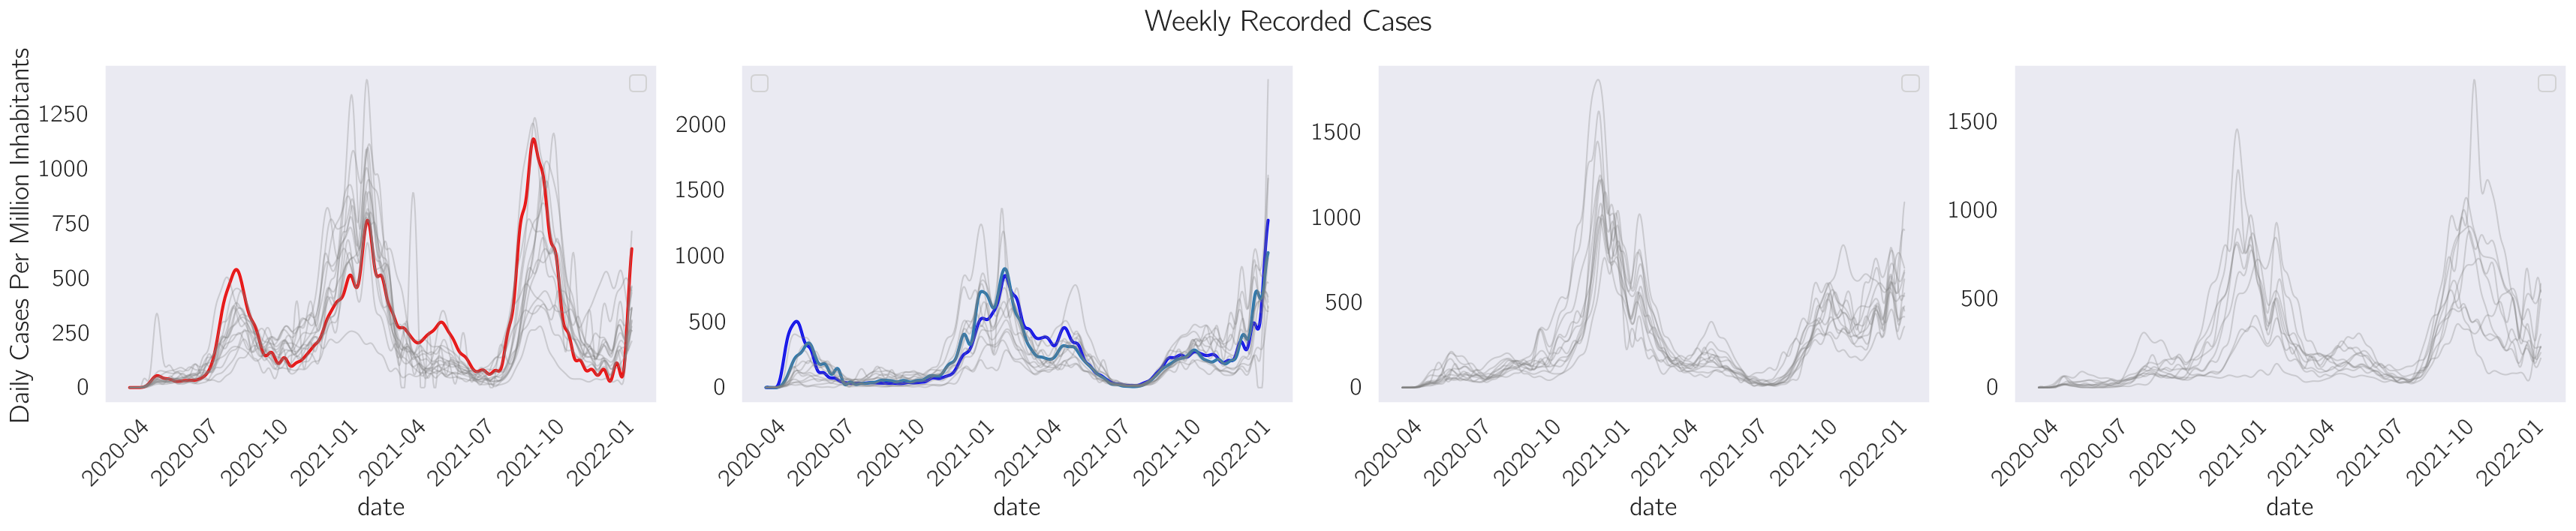

In [133]:
pca = cfr.pca_plot(smooth, 'CasesPerPeriod', n_comps=4, plot=False)
groups = cfr.partition(pca, smooth)  # leiden clustering
fig, ax = cfr.plot_partitions(smooth, 'CasesPerPeriod', groups,
                              pivot_kwargs={'transform': lambda x: x})
fig.suptitle('Weekly Recorded Cases', fontsize=20)
ax[0].set_ylabel('Daily Cases Per Million Inhabitants')
plt.tight_layout()

In [290]:
from pandas.api.types import CategoricalDtype
from sklearn.cluster import KMeans

data = smooth[smooth.group == 0]
def compute_waves(smooth):
    data = smooth.pivot(columns='state', values='CasesPerPeriod').dropna(axis=0)

    km = KMeans(4)
    km.fit(data)

    data['label'] = km.labels_
    data.label = data.label.astype('category')
    order = CategoricalDtype(categories=data.label.unique(), ordered=True)
    data.label = data.label.astype(order)

    # 
    x = []
    beginning = data.label.unique()[0]
    k = 0
    prev_value = beginning
    print(beginning)
    for i in data.label.values:
        # no change, and the new i is beginning i:
        if (prev_value != i) & (i == beginning):
            print(prev_value, i, k)
            k += 1
        prev_value = i

        if k > 3:
            k = 3
        x += [k]

    # 
    data['wave'] = x
    data.wave = data.wave.astype('category')

    data = data.reset_index().melt(var_name='state', value_name='CasesPerPeriod',
                                   id_vars=['label', 'date', 'wave'])
    data['wave_start'] = data.groupby(['state', 'wave']).date.transform(np.min)
    data['WaveDay'] = (data.date - data.wave_start).astype('timedelta64[D]').astype('int')

    grouped = data.groupby(['wave', 'WaveDay']).CasesPerPeriod.mean().reset_index()
    grouped['difference'] = grouped.groupby(['wave', 'WaveDay']).CasesPerPeriod.fillna(0).diff()
    grouped[grouped.difference.abs() > 20] = np.nan

    wave_min_dict = grouped[grouped.difference > 8].groupby(['wave']).WaveDay.min().astype(int).to_dict()

    data['wave_min'] = data.wave.map(wave_min_dict).astype(int)
    data['wavename'] = data.groupby('wave').date.transform(np.min)
    data['AlignedWaveDay'] = data.WaveDay - data.wave_min

    cases_dict = data[data.AlignedWaveDay == 0].groupby(['wave', 'state']).CasesPerPeriod.min().to_dict()
    data['cases_at_start'] = data.apply(lambda x: cases_dict[(x.wave, x.state)], axis=1)
    data['AlignedCases'] = data.CasesPerPeriod - data.cases_at_start
    return data

waves = pd.concat([compute_waves(smooth[smooth.group == i]) for i in range(smooth.group.max())])
waves.wave = waves.wave.astype('category')
waves.label = waves.label.astype('category')

<AxesSubplot:xlabel='date', ylabel='CasesPerPeriod'>

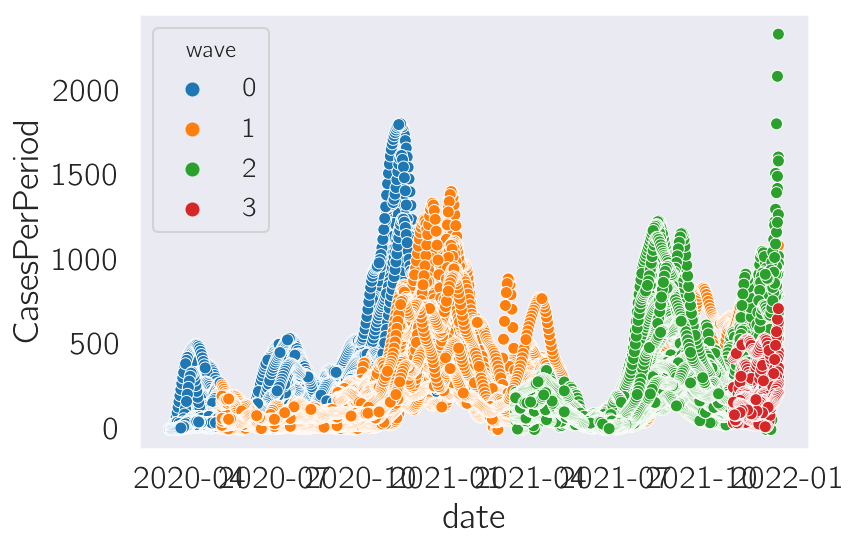

In [345]:
sns.scatterplot(x='date', y='CasesPerPeriod', hue='wave', data=waves.sort_values('wave'))

<AxesSubplot:xlabel='date', ylabel='CasesPerPeriod'>

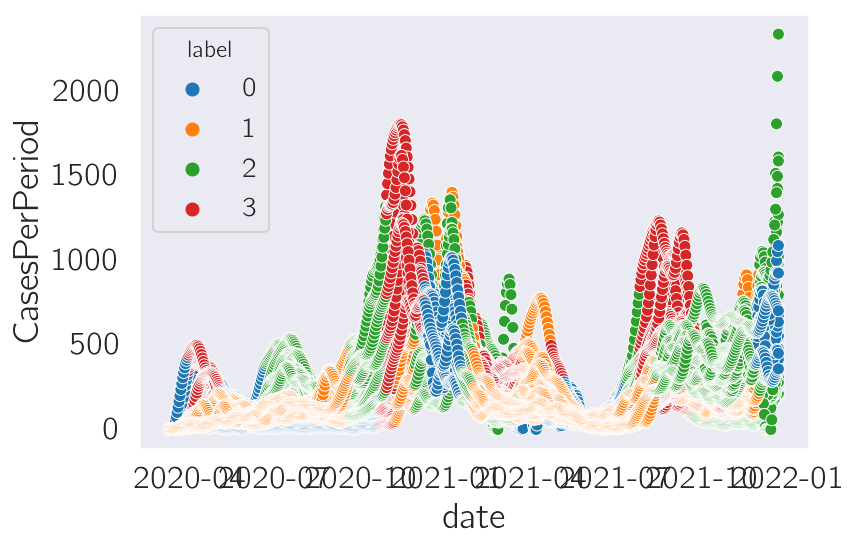

In [291]:
sns.scatterplot(x='date', y='CasesPerPeriod', hue='label', data=waves)

<AxesSubplot:xlabel='WaveDay', ylabel='CasesPerPeriod'>

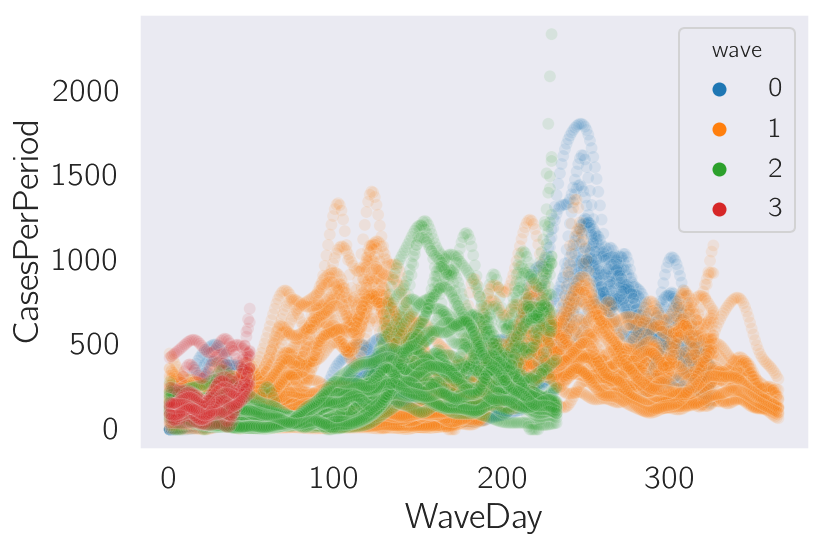

In [293]:
sns.scatterplot(x='WaveDay', y='CasesPerPeriod', hue='wave', data=waves.sort_values('wave'), alpha=0.1)

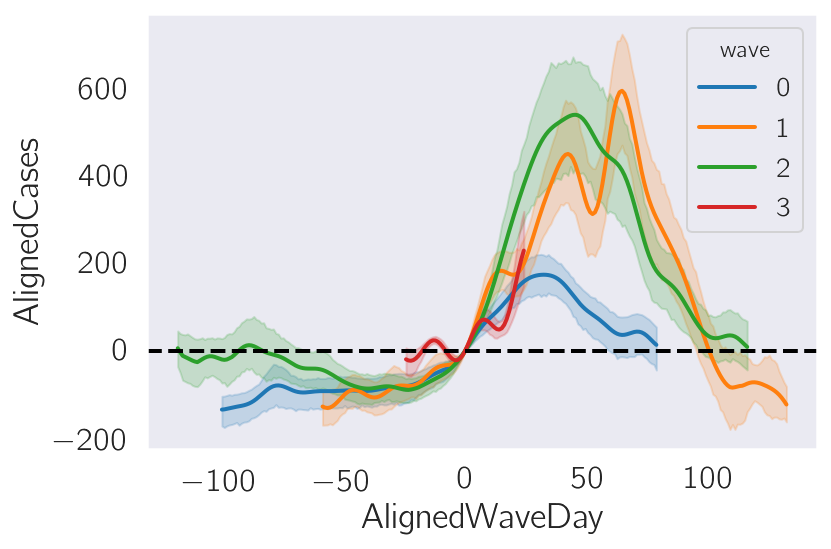

In [265]:
sns.lineplot(x='AlignedWaveDay', y='AlignedCases', hue='wave', data=data.sort_values('wave'))
plt.axhline(0, ls='--', color='black')

In [302]:
# data.groupby('wave').date.transform(np.min)


(-50.0, 800.0)

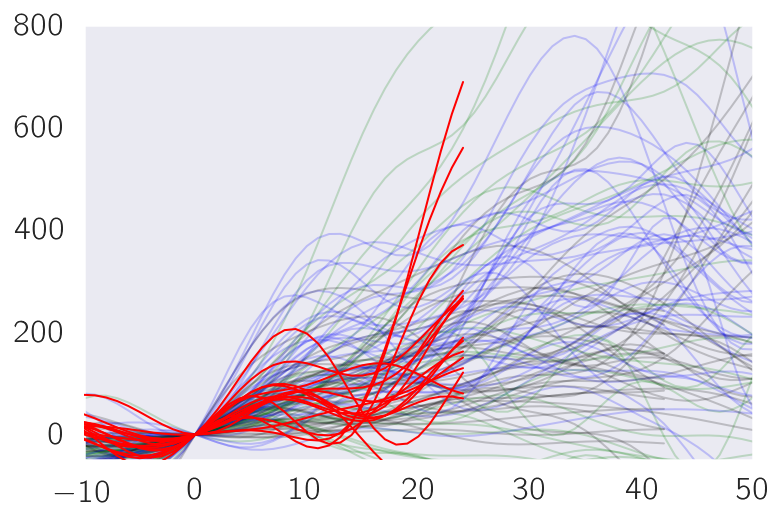

In [336]:
colors = {0: 'black', 1: 'blue', 2: 'green', 3: 'red'}

fig, ax = plt.subplots()
for name, group in waves.groupby(['state', 'wave']):

    if name[1] == 3:
        zorder = np.inf
        alpha = 1
    else:
        zorder = 0
        alpha = 0.2
    ax.plot(group.AlignedWaveDay, group.AlignedCases, color=colors[name[1]], lw=1, zorder=zorder, alpha=alpha)

plt.xlim(-10, 50)
plt.ylim(-50, 800)

Text(0.5, 1.0, 'Comparison of Slopes of successive waves')

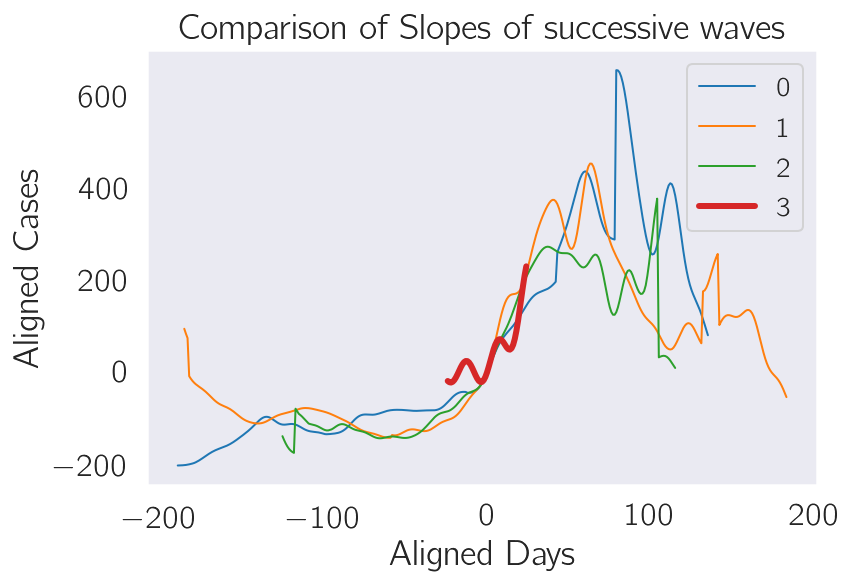

In [346]:
mean_wave = waves.groupby(['wave', 'AlignedWaveDay']).mean().reset_index()
for w, group in mean_wave.groupby('wave'):
    if w == 3:
        lw = 3
    else:
        lw = 1
    plt.plot(group.AlignedWaveDay, group.AlignedCases, lw=lw, label=w)
plt.legend()

plt.xlabel('Aligned Days')
plt.ylabel('Aligned Cases')
plt.title('Comparison of Slopes of successive waves')